In [108]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import plotting

In [109]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [110]:
# quite good with @tf.fuinction
@tf.function
def custom_activation(x):
    return tf.sin(x)

In [111]:
def setup_model() -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((2,)),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=1),
        ]
    )

    model.summary()
    model.compile(optimizer="Adam", loss="mean_squared_error")
    return model, tf.keras.optimizers.Adam(learning_rate=0.001)

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}=f$

In [112]:
tf_pi = tf.constant(np.pi)


def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# TODO: experiment with tf function and parameters
@tf.function
def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

### Params

In [113]:
grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 4

In [114]:
def get_area(grid_size, border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1], border_grid_size[1], dtype=np.float32)

    border = mesh_to_pairs(np.meshgrid(x, y)).reshape(border_grid_size[0], border_grid_size[1], 2)
    border_01 = np.append(border[0], border[0][..., [1, 0]])
    border_02 = np.append(border[-1], border[-1][..., [1, 0]])

    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y)),\
        np.append(border_01, border_02).reshape(border_grid_size[0] * 4, 2)

def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [115]:
@tf.function
def ode_system(coord, border, net):
    # set type to avoid overcalculations
    # border = tf.constant(border, dtype=tf.float32)
    # coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [116]:
# train model
@tf.function
def train_with_loss(train_coord, border, net, optm):
    for itr in tf.range(0, 6000):
        with tf.GradientTape() as tape:
            train_loss = ode_system(train_coord, border, net)
            # train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, net.trainable_variables)
        optm.apply_gradients(zip(grad_w, net.trainable_variables))
        del tape

        if itr % 500 == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss)  #.numpy())
            if train_loss < 0.01:
                break

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 0 loss: 93.8484
epoch: 500 loss: 0.121133327
epoch: 1000 loss: 0.0282455422
epoch: 1500 loss: 0.00996790547


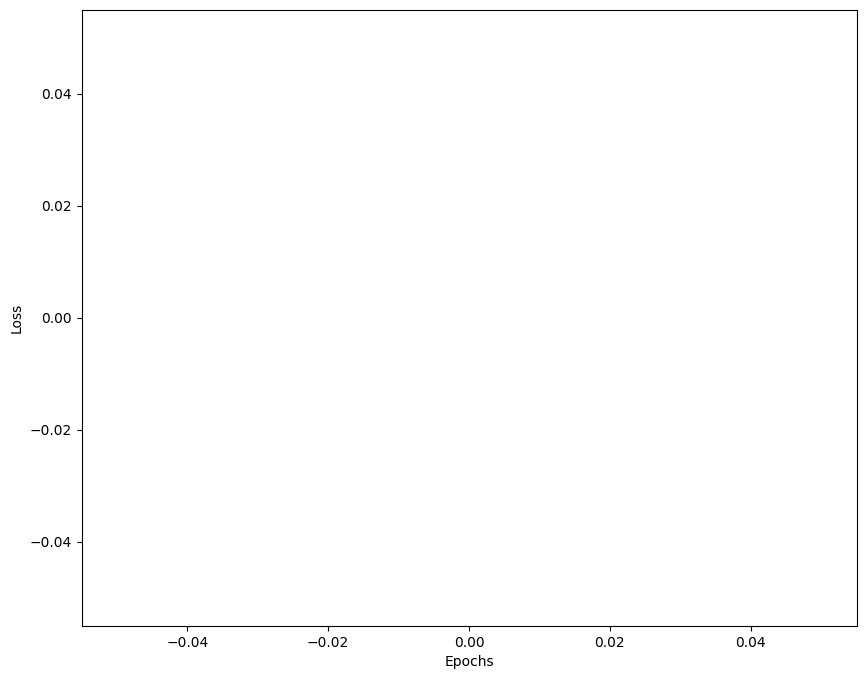

In [117]:
model, optm = setup_model()
train_loss_record = []
train_with_loss(*get_area(grid_size, border_grid_size, x_limits, y_limits),
                model, optm)
plotting.NNPlots.plotLoss(train_loss_record)

In [118]:
# NN.save("model.h5")
# NN = tf.keras.models.load_model("model.h5")

In [119]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""

test_x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(grid_size[0], grid_size[1])

NameError: name 'x' is not defined

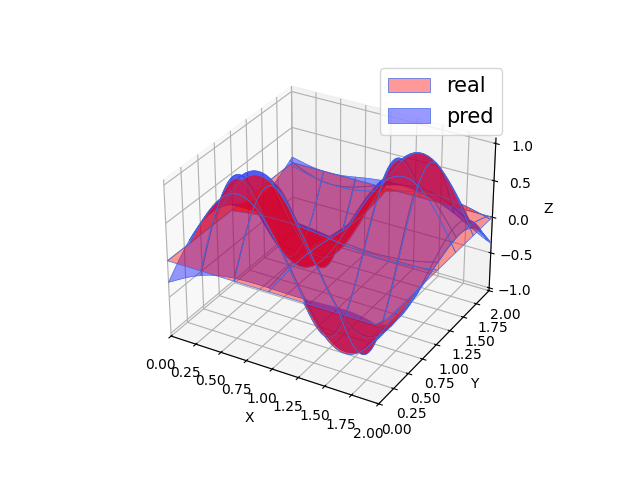

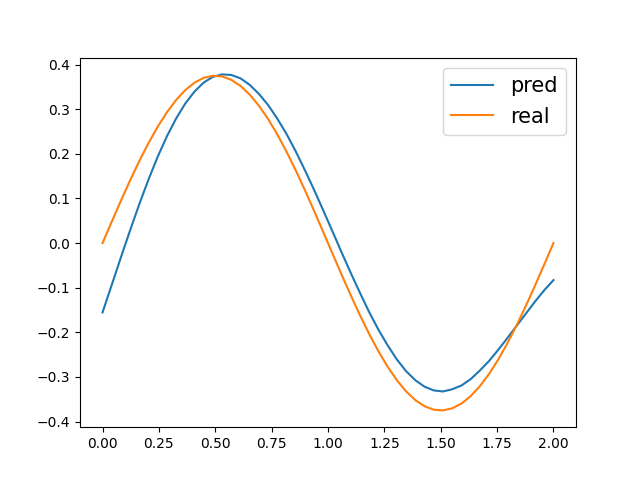

In [172]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
plotter.plot3d()
plotter.plot2d_fix_x(3)

# Accuracy calculation

In [173]:
pred = np.array([i[0] for i in pred_u.reshape(np.prod(pred_u.shape), 1)])
true = np.array([i[0] for i in true_u.reshape(np.prod(true_u.shape), 1)])

In [174]:
from accuracy import *

print("Accuracy:", good_perc(pred, true), maape(pred, true))

SyntaxError: expected ':' (accuracy.py, line 27)